# Tensorflow details


## TODO

- Work out how to handle variable-sized input (masking?)
  - If masking, should it be sparse?
- Work out how to integrate into standard optimizers with minimum messing about
- Can I do FFT or other such optimised transforms inside the loop?
- can I export a binary?

## installation
[latest version](https://www.tensorflow.org/versions/r0.9/get_started/os_setup.html)

### Mac OS
``export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/mac/tensorflow-0.9.0-py3-none-any.whl``
### Linux GPU
``export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/linux/gpu/tensorflow-0.9.0-cp34-cp34m-linux_x86_64.whl``
### Linux no-GPU
``export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/linux/cpu/tensorflow-0.9.0-cp34-cp34m-linux_x86_64.whl``

### Everyone

Finally
``pip install --upgrade $TF_BINARY_URL``

## How to do stuff

- [placeholder variables explained through MNIST](https://www.tensorflow.org/versions/r0.8/tutorials/mnist/beginners/index.html#implementing-the-regression)
  - [going deeper on how that works, still with MNIST](https://www.tensorflow.org/versions/r0.8/tutorials/mnist/tf/index.html)
- [graphs and sessions](https://www.tensorflow.org/versions/r0.8/get_started/basic_usage.html)
- [abusing tensorflow for cheezy time-dependent PDEs](https://www.tensorflow.org/versions/r0.8/tutorials/pdes/index.html)
- [abusing tensorflow for cheezy Mandelbrot sets](https://www.tensorflow.org/versions/r0.8/tutorials/mandelbrot/index.html)
- [shared variables a.k.a. scope in Tensorflow](https://www.tensorflow.org/versions/r0.8/how_tos/variable_scope/index.html)
- [variables are pointers to tensor buffers](https://www.tensorflow.org/versions/r0.8/how_tos/variables/index.html)
- [data types](https://www.tensorflow.org/versions/r0.8/resources/dims_types.html)
- [high performance parallel tensorflow](https://www.tensorflow.org/versions/r0.8/how_tos/distributed/index.html)


In [1]:
import numpy as np
import warnings
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy import stats
from importlib import reload
from src import sim_cts, sim_discrete
from scipy.stats import poisson, geom
import tensorflow as tf

In [2]:
## web graphics
%matplotlib inline
## interactive graphics
#%matplotlib notebook
## SVG graphics
#%config InlineBackend.figure_format = 'svg' 

In [3]:
# plotting requirements
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from src.rng import default_random_state

## basic use

First we create a Graph, which is some kind of computational graph abstraction which will be executed later.

We then create a session object that encapsulates the connection between our graph and the weird morass of C++/GPU task distribution and graph compilation and so on.

A clear example of doing this is in the [MNIST tutorial](https://github.com/tensorflow/tensorflow/blob/r0.8/tensorflow/examples/tutorials/mnist/mnist.py).

In [5]:
#This is making a Graph implicity (or at least, puting operations onto the default graph)

# Create a Constant op that produces a 1x2 matrix.  The op is
# added as a node to the default graph.
#
# The value returned by the constructor represents the output
# of the Constant op.
matrix1 = tf.constant([[3., 3.]])

# Create another Constant that produces a 2x1 matrix.
matrix2 = tf.constant([[2.],[2.]])

# Create a Matmul op that takes 'matrix1' and 'matrix2' as inputs.
# The returned value, 'product', represents the result of the matrix
# multiplication.
product = tf.matmul(matrix1, matrix2)

In [6]:
# Launch the session, which will execute, per default, the default Graph when we request operations from it..
sess = tf.Session()
# To run the matmul op we call the session 'run()' method, passing 'product'
# which represents the output of the matmul op.  This indicates to the call
# that we want to get the output of the matmul op back.
#
# All inputs needed by the op are run automatically by the session.  They
# typically are run in parallel.
#
# The call 'run(product)' thus causes the execution of three ops in the
# graph: the two constants and matmul.
#
# The output of the op is returned in 'result' as a numpy `ndarray` object.
result = sess.run(product)
print(result)
# ==> [[ 12.]]

# Close the Session when we're done.
sess.close()

[[ 12.]]


In [7]:
with tf.Session() as sess:
  result = sess.run(product)
  print(result)

[[ 12.]]


## Interactive style session
For ease of use in interactive Python environments, such as `IPython` you can instead use the `InteractiveSession` class, and the `Tensor.eval()` and `Operation.run()` methods. This avoids having to keep a variable holding the session.

An [MNIST example of this](https://github.com/tensorflow/tensorflow/blob/r0.8/tensorflow/examples/tutorials/mnist/mnist_softmax.py)

In [8]:
# Enter an interactive TensorFlow Session.
import tensorflow as tf
sess = tf.InteractiveSession()

x = tf.Variable([1.0, 2.0])
a = tf.constant([3.0, 3.0])

# Initialize 'x' using the run() method of its initializer op.
x.initializer.run()

# Add an op to subtract 'a' from 'x'.  Run it and print the result
sub = tf.sub(x, a)
print(sub.eval())
# ==> [-2. -1.]


[-2. -1.]


In [9]:
# Close the Session when we're done.
sess.close()

## placeholders, variables, scope

- `placeholder`: input _data_ that we expect to be filled in with, e.g. minibatches of observations,
- `Variables`: parameters that we might expect to update inside the loop
- `Scope`: a scope to manage shared variables, like a class instance's member variables (which would be an alternative and also simple way to manage this thingy.) 


## Iteration
[MNIST levels up](https://github.com/tensorflow/tensorflow/blob/r0.8/tensorflow/examples/tutorials/mnist/fully_connected_feed.py)

# linear regression
Is a good sanity check.

In [10]:
x_data = np.random.rand(10000).astype(np.float32)
y_data = x_data * 5 + 0.3 + np.random.normal(scale=2, size=x_data.size)


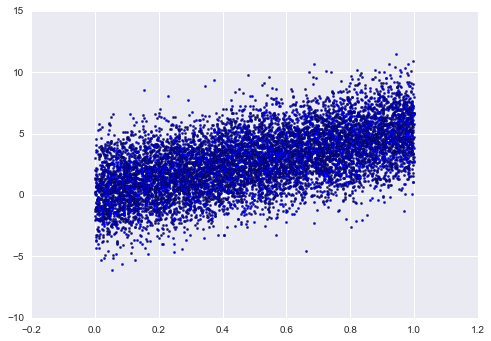

In [11]:
plt.scatter(x_data, y_data, marker='.');

In [12]:
W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
b = tf.Variable(tf.zeros([1]))
y = W * x_data + b

In [13]:
# Minimize the mean squared errors.
loss = tf.reduce_mean(tf.square(y - y_data))
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

In [15]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
for step in range(201):
    sess.run(train)
    if step % 20 == 0:
        print(step, sess.run(W), sess.run(b))


0 [ 2.08663654] [ 2.58481169]
20 [ 4.18459034] [ 0.74217349]
40 [ 4.80947065] [ 0.40969181]
60 [ 4.97222519] [ 0.32309464]
80 [ 5.01461649] [ 0.30053958]
100 [ 5.0256567] [ 0.29466513]
120 [ 5.02853298] [ 0.29313493]
140 [ 5.02928162] [ 0.29273662]
160 [ 5.02947712] [ 0.29263252]
180 [ 5.02952766] [ 0.29260573]
200 [ 5.02954102] [ 0.29259861]


In [16]:
sess.close()

So that worked beautifully with TF's own built-in optimizer. But how do we use an external optimiser?
``tf.contrib.opt.ScipyOptimizerInterface``.

More generally, internal loops can be constructed using  [control flow operations](https://www.tensorflow.org/versions/r0.8/api_docs/python/control_flow_ops.html#control-flow-operations).


Now I want to know how to mask variables for use in my estimators

In [17]:
a=tf.Variable([[-3.3, -2, -1,0,1,2,3],[-3, -2, -1,0,1,2,3],[-3, -2, -1,0,1,2,3],], name="a")
b=tf.maximum(tf.sign(a), 0)

In [18]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
b.eval()

array([[ 0.,  0.,  0.,  0.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  1.]], dtype=float32)

## Gotchas

### Ops or values?

Surprising things are Ops, which must not only be created but then run in a separate step, e.g.
```
var.assign(val) # Doesn't do much
sess.run(var.assign(val)) # updates value of var
```
Getting values doesn't require creating intermediate Ops 
```
var.eval(sess)
```
### default Sessions and default Graphs accumulate crap 

It's  annoying for moderately complex graphs, keeping a default graph monster around in global variables, so I don't recommend it.
If you rebuild the graph you instead find you have accidentally concatenated it with your new graph. Confusing errors result.

Generally, if you don't want colliding ops I'd recommend passing graphs about deliberately; But beware, then Ops don't go in the correct graph per default; you have to do
```
with g.as_default_graph():
    #blah
```
Additionally you might need to have a default sessions
```
with sess.as_default():
    #blah
sess.close() #still necessary.
```
